In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras import optimizers

In [ ]:

df = pd.read_csv('NVidia_stock_history.csv')
df['Date'] = pd.to_datetime(df['Date'], utc=True)

df.dropna(subset=['Date'], inplace=True)

df = df.set_index('Date')
df = df.sort_index()

df_features = df.select_dtypes(include=['int64','float64']).copy()
df_features.dropna(inplace=True)


#Scaling Data 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features)

close_col_index = df_features.columns.get_loc('Close')
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaler_target.fit(df_features[['Close']].values.reshape(-1, 1))

MinMaxScaler()

In [15]:
#Create Time Series Sequences
time_step = 5 # Look back period (days)
X_data, y_data = [], []


for i in range(time_step, len(scaled_data)):

    X_data.append(scaled_data[i-time_step:i, :])
    y_data.append(scaled_data[i, close_col_index])

# Convert lists to NumPy arrays
X_data, y_data = np.array(X_data), np.array(y_data)

In [11]:
#Train/Test Split
split_ratio = 0.8
split_index = int(len(X_data) * split_ratio)

X_train, X_test = X_data[:split_index], X_data[split_index:]
y_train, y_test = y_data[:split_index], y_data[split_index:]

n_features = X_train.shape[2]
print(f"Number of features: {n_features}")

Number of features: 7


In [12]:
#Build LSTM Model
tf.keras.backend.clear_session()

model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(time_step, n_features)),
    LSTM(units=64, return_sequences=False), 
    Dense(units=128, activation = "relu"), 
    Dropout(0.5),
    Dense(units=1) 
])

model.compile(optimizer='adam', 
              loss='mse',
              metrics = [keras.metrics.RootMeanSquaredError()])

model.summary()

#Train the Model 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

training = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 59,905
Trainable params: 59,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
81/81 [==============================] - 

In [13]:
#Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_inv = scaler_target.inverse_transform(train_predict)
test_predict_inv = scaler_target.inverse_transform(test_predict)

#Inverse transform the actual test target values as well for comparison
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_train_inv = scaler_target.inverse_transform(y_train.reshape(-1, 1)) # For train RMSE

#Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_mae = mean_absolute_error(y_test_inv, test_predict_inv)

print("\n--- Model Evaluation ---")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Test MAE:   {test_mae:.4f}")

original_y_test = df_features['Close'][split_index+time_step:].values
print(f"Standard Deviation of Test Set Actual 'Close' Prices: {np.std(original_y_test):.4f}")

41/41 [==============================] - 0s 2ms/step

--- Model Evaluation ---
Train RMSE: 0.1666
Test RMSE:  4.6437
Test MAE:   2.0629
Standard Deviation of Test Set Actual 'Close' Prices: 29.1257


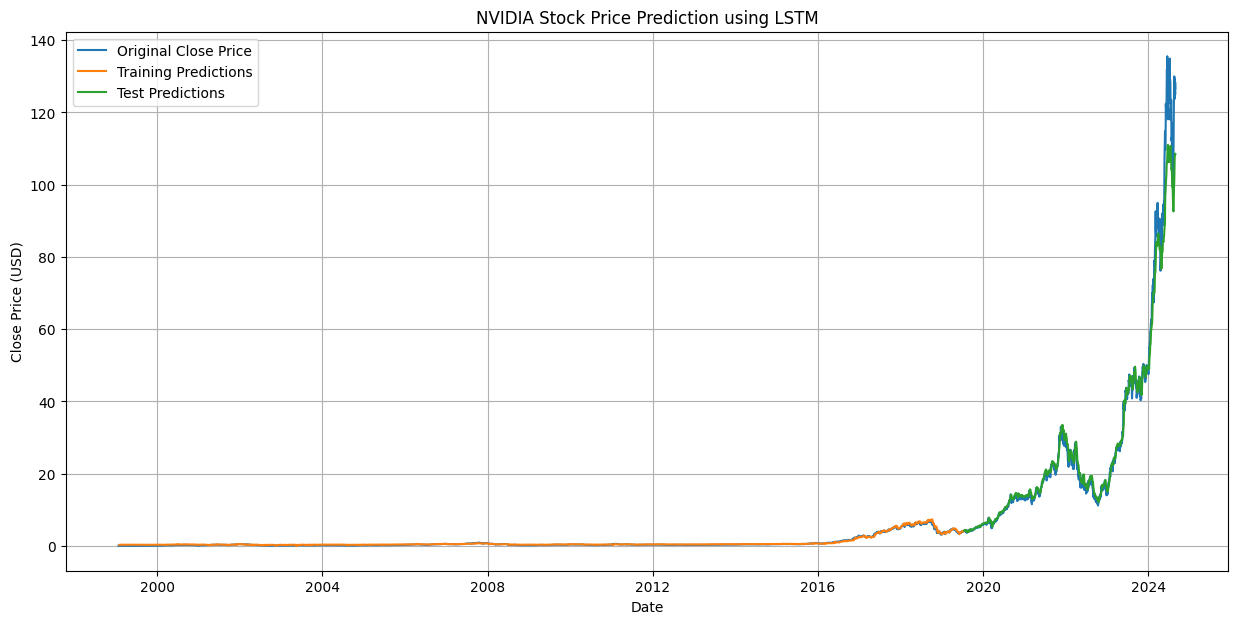

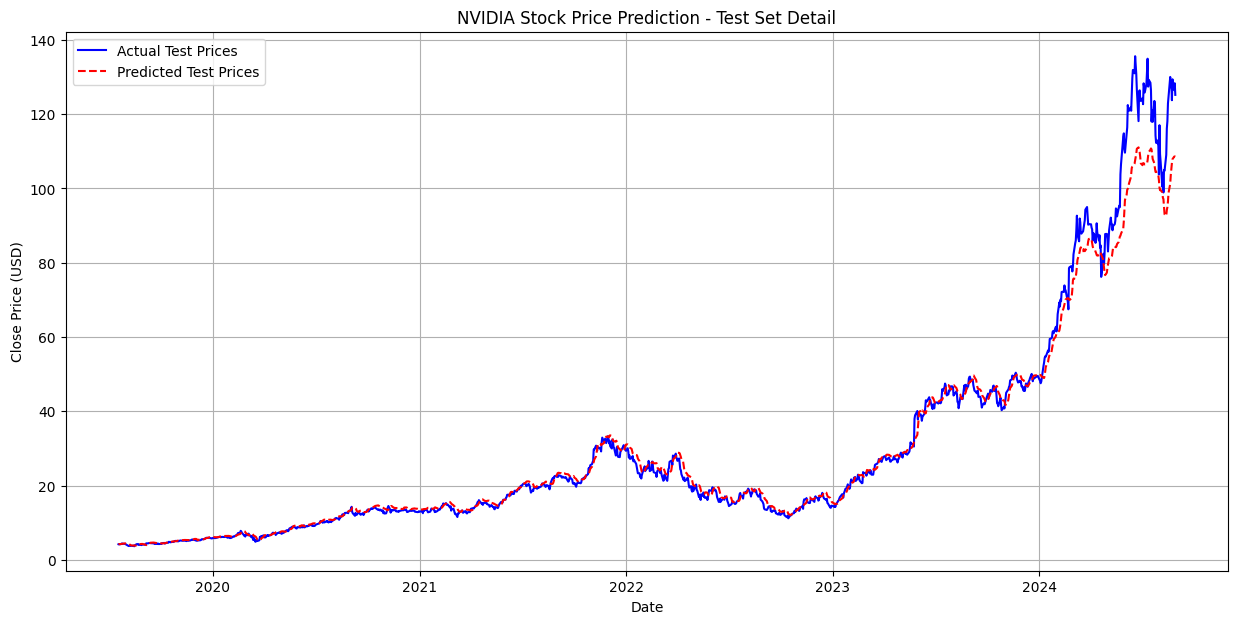

In [14]:
# --- Visualize Predictions ---

# Create arrays for plotting train predictions
train_predict_plot = np.empty_like(scaled_data[:, close_col_index:close_col_index+1]) # Use only Close column index
train_predict_plot[:, :] = np.nan
# Place predictions at the correct indices in the plot array
train_predict_plot[time_step:len(train_predict_inv)+time_step, :] = train_predict_inv

# Create arrays for plotting test predictions
test_predict_plot = np.empty_like(scaled_data[:, close_col_index:close_col_index+1])
test_predict_plot[:, :] = np.nan
# Place predictions at the correct indices
# Corrected line:
start_index_test = len(train_predict_inv) + time_step # This is split_index + time_step
test_predict_plot[start_index_test:len(scaled_data), :] = test_predict_inv
# Plot baseline (original data) and predictions
plt.figure(figsize=(15, 7))
plt.plot(df_features.index, scaler_target.inverse_transform(scaled_data[:, close_col_index:close_col_index+1]), label='Original Close Price') # Plot original Close
plt.plot(df_features.index, train_predict_plot, label='Training Predictions')
plt.plot(df_features.index, test_predict_plot, label='Test Predictions')
plt.title('NVIDIA Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plotting focus on Test Set ---
test_dates = df_features.index[split_index+time_step:] # Get dates corresponding to y_test

plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_inv, label='Actual Test Prices', color='blue')
plt.plot(test_dates, test_predict_inv, label='Predicted Test Prices', color='red', linestyle='--')
plt.title('NVIDIA Stock Price Prediction - Test Set Detail')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()